In [1]:
import os, random, math, time
from pathlib import Path
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.transforms import RandAugment
import timm

In [3]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from collections import Counter

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda": torch.cuda.manual_seed_all(SEED)

Device: cuda


In [5]:
IMG_SIZE = 224
BATCH_SIZE = 8         # adjust if OOM
EPOCHS = 30
NUM_WORKERS = 4         # set 0 if worker issues on Kaggle
LR = 3e-4
LABEL_SMOOTH = 0.1
SAVE_PATH = "best_model.pth"
USE_SEGMENTATION = True

# Loss weights from PDF suggestion
ALPHA_DOM = 0.5
BETA_SUPCON = 0.3
ETA_CONS = 0.1
GAMMA_SEG = 0.5

# Mixup/CutMix probabilities and alphas
PROB_MIXUP = 0.5
PROB_CUTMIX = 0.5
MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 1.0

# warmup epochs
WARMUP_EPOCHS = 5

# early stopping
EARLY_STOPPING_PATIENCE = 15
FREEZE_EPOCHS = 5
ACCUMULATION_STEPS = 4

## Noise + Transform

In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0., 1.)
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

weak_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.02),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
strong_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    RandAugment(num_ops=2, magnitude=9),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [7]:
weak_tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
strong_tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()]) # Placeholder for actual strong transform
val_tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])

# Function to try reading a file with multiple encodings
def read_file_with_encoding(file_path, encodings=['utf-8', 'utf-8-sig', 'ISO-8859-1']):
    """Tries to read a file using a list of common encodings."""
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.readlines()
        except UnicodeDecodeError:
            print(f"Failed to read {file_path} with encoding {encoding}")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    raise RuntimeError(f"Unable to read {file_path} with any of the provided encodings.")

def load_testing_dataset_info(info_file, image_dir):
    """Loads image paths and labels from the testing dataset info file."""
    image_paths = []
    labels = []
    
    # List of encodings to try
    encodings = ['utf-8-sig', 'utf-8', 'ISO-8859-1', 'latin-1']
    lines = []
    
    for encoding in encodings:
        try:
            with open(info_file, 'r', encoding=encoding) as f:
                lines = f.readlines()
            break  # If successful, break out of the loop
        except UnicodeDecodeError:
            print(f"Failed to read {info_file} with encoding {encoding}. Trying another encoding...")
        except Exception as e:
            print(f"Error reading {info_file}: {e}")
            raise  # Raise the error if it's something unexpected
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 2:
            image_filename = parts[0]
            # Ensure label is always 0 or 1
            try:
                label = int(parts[1])
            except ValueError:
                continue # Skip malformed lines
                
            label = 1 if label == 1 else 0  # Map label '1' to CAM and '0' to Non-CAM
            image_full_path = os.path.join(image_dir, image_filename)  # Combine with image directory
            image_paths.append(image_full_path)
            labels.append(label)
    
    return image_paths, labels


# MultiDataset class with proper encoding handling
class MultiDataset(Dataset):
    def __init__(self, root_dirs, txt_files, testing_image_paths=None, testing_labels=None, weak_transform=None, strong_transform=None, use_masks=True):
        self.root_dirs = root_dirs
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.use_masks = use_masks
        self.samples = []

        # Handle the testing dataset (testing-dataset images and labels)
        if testing_image_paths is not None and testing_labels is not None:
            for img_path, label in zip(testing_image_paths, testing_labels):
                # Samples from testing-dataset are stored as 2-element tuples (img_path, label)
                self.samples.append((img_path, label)) 
        
        # Process other datasets (COD10K, CAMO, etc.)
        if isinstance(txt_files, str):
            txt_files = [txt_files]

        all_lines = []
        for t in txt_files:
            if not os.path.exists(t):
                raise RuntimeError(f"TXT file not found: {t}")

            # Use the read_file_with_encoding function to handle different encodings
            lines = read_file_with_encoding(t)
            all_lines.extend([(line.strip(), t) for line in lines if line.strip()])

        for line, src_txt in all_lines:
            parts = line.split()
            if len(parts) == 0:
                continue

            fname = parts[0]
            if len(parts) >= 2:
                try:
                    lbl = int(parts[1])
                except:
                    # Fallback classification if label is not an integer
                    lbl = 1 if "CAM" in fname or "cam" in fname else 0
            else:
                lbl = 1 if "CAM" in fname or "cam" in fname else 0
            
            # Map labels to binary (CAM=1, Non-CAM=0)
            lbl = 1 if lbl == 1 else 0

            found = False
            search_subs = [
                "",  # If image is directly in root_dir (less common)
                "Image", "Imgs", "images", "JPEGImages", "img", # Common image folders 
                "Images/Train", "Images/Test", # CAMO-COCO style paths
            ]
            
            base_fname = os.path.basename(fname)  

            for rdir in self.root_dirs:
                for sub in search_subs:
                    img_path = os.path.join(rdir, sub, base_fname)
                    if os.path.exists(img_path):
                        # Samples from COD/CAMO are stored as 3-element tuples (img_path, lbl, rdir)
                        self.samples.append((img_path, lbl, rdir))
                        found = True
                        break
                if found:
                    break

            if not found:
                print(f"[WARN] File not found in any root: {base_fname} (Searched in {self.root_dirs})")

        if len(self.samples) == 0:
            raise RuntimeError(f"No valid samples found from {txt_files}")

        print(f"✅ Loaded {len(self.samples)} samples from {len(self.root_dirs)} root directories.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        global IMG_SIZE 
        
        sample = self.samples[idx]
        
        # 1. SAFELY UNPACK sample tuple (length 2 or 3)
        img_path = sample[0]
        lbl = sample[1]
        
        # Define rdir for consistent mask lookup logic
        if len(sample) == 3:
            # If it's a 3-element tuple (COD/CAMO), rdir is the third element
            rdir = sample[2]
            # Root directory for testing-dataset (used as fallback for mask lookup)
            testing_root = None 
        else:
            rdir = os.path.dirname(os.path.dirname(img_path))


        img = Image.open(img_path).convert("RGB")

        if self.weak_transform:
            weak = self.weak_transform(img)
        else:
            weak = transforms.ToTensor()(img)
            
        if self.strong_transform:
            strong = self.strong_transform(img)
        else:
            strong = weak.clone()

        mask = None
        if self.use_masks:
            mask_name = os.path.splitext(os.path.basename(img_path))[0] + ".png"
            
            # Use the defined rdir for mask search
            found_mask = False
            for mask_dir in ["GT_Object", "GT", "masks", "Mask"]:
                mask_path = os.path.join(rdir, mask_dir, mask_name)
                
                if os.path.exists(mask_path):
                    m = Image.open(mask_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
                    m = np.array(m).astype(np.float32) / 255.0
                    # Convert to binary mask: 0 or 1
                    mask = torch.from_numpy((m > 0.5).astype(np.float32)).unsqueeze(0)
                    found_mask = True
                    break

            if mask is None:
                mask = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
                
        return weak, strong, lbl, mask

def build_weighted_sampler(dataset):
    """
    Builds a WeightedRandomSampler based on class imbalance.
    FIXED: Safely extracts label (index 1) from both 2-element and 3-element tuples.
    """
    
    # Safely extract labels (always index 1, regardless of tuple length)
    labels = [sample[1] for sample in dataset.samples]  
    
    counts = Counter(labels)
    total = len(labels)
    
    # Ensure there are at least two classes to calculate class_weights
    if len(counts) <= 1:
        print(f"[WARN] Only {len(counts)} class(es) found. Using equal weights.")
        weights = [1.0] * total
    else:
        # Calculate inverse frequency weights
        class_weights = {c: total / (counts[c] * len(counts)) for c in counts}
        weights = [class_weights[lbl] for lbl in labels]
        
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

## Dataset

In [8]:
info_dir = "/kaggle/input/cod10k/COD10K-v3/Info"
train_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Train" 
test_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Test"  
    
# COD10K Info files
train_cam_txt = os.path.join(info_dir, "CAM_train.txt")
train_noncam_txt = os.path.join(info_dir, "NonCAM_train.txt")
test_cam_txt = os.path.join(info_dir, "CAM_test.txt")
test_noncam_txt = os.path.join(info_dir, "NonCAM_test.txt")

# CAMO-COCO PATHS
info_dir2 = "/kaggle/input/camo-coco/CAMO_COCO/Info"

# CAMO-COCO Info files
train_cam_txt2 = os.path.join(info_dir2, "camo_train.txt")
train_noncam_txt2 = os.path.join(info_dir2, "non_camo_train.txt")
test_cam_txt2 = os.path.join(info_dir2, "camo_test.txt")
test_noncam_txt2 = os.path.join(info_dir2, "non_camo_test.txt")

# CAMO-COCO Root Directories
train_dir_camo_cam = "/kaggle/input/camo-coco/CAMO_COCO/Camouflage"
train_dir_camo_noncam = "/kaggle/input/camo-coco/CAMO_COCO/Non_Camouflage"

testing_info_file = "/kaggle/input/testing-dataset/Info/image_labels.txt"
testing_images_dir = "/kaggle/input/testing-dataset/Images"
testing_image_paths, testing_labels = load_testing_dataset_info(testing_info_file, testing_images_dir)

# Split testing-dataset: 20% train (train_paths), 80% validation (val_paths)
# testing dataset: NC4K+places365 (images and labels text file)
from sklearn.model_selection import train_test_split # Make sure this import is present
train_paths, val_paths, train_labels, val_labels = train_test_split(
    testing_image_paths, testing_labels, test_size=0.8, random_state=42
)

# 1. All Root Directories
ALL_ROOT_DIRS = [
    train_dir_cod,       
    test_dir_cod,       
    train_dir_camo_cam,  
    train_dir_camo_noncam
]

# 2. Training TXT files: ALL COD10K/CAMO-COCO data (both train and test splits)
ALL_TRAIN_TXTS = [
    train_cam_txt, train_noncam_txt, test_cam_txt, test_noncam_txt,
    train_cam_txt2, train_noncam_txt2, test_cam_txt2, test_noncam_txt2,
]

# 3. Validation TXT files: ONLY the 80% testing-dataset split will be used, so this list is empty.
ALL_VAL_TXTS = []

# Training Dataset: All external data (via ALL_TRAIN_TXTS) + 20% testing-dataset split (via train_paths)
train_ds = MultiDataset(
    root_dirs=ALL_ROOT_DIRS, 
    txt_files=ALL_TRAIN_TXTS,               
    testing_image_paths=train_paths,        
    testing_labels=train_labels,            
    weak_transform=weak_tf, 
    strong_transform=strong_tf, 
    use_masks=USE_SEGMENTATION
)

# Validation Dataset: No external data (via empty ALL_VAL_TXTS) + 80% testing-dataset split (via val_paths)
val_ds = MultiDataset(
    root_dirs=ALL_ROOT_DIRS,  
    txt_files=ALL_VAL_TXTS,                 
    testing_image_paths=val_paths,          
    testing_labels=val_labels,              
    weak_transform=val_tf, 
    strong_transform=None, 
    use_masks=USE_SEGMENTATION
)

# Build Sampler and DataLoader
train_sampler = build_weighted_sampler(train_ds)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Total Train samples:", len(train_ds), "Total Val samples:", len(val_ds))


✅ Loaded 14150 samples from 4 root directories.
✅ Loaded 6606 samples from 4 root directories.
Total Train samples: 14150 Total Val samples: 6606


## Backbones

In [9]:
class DenseNetExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.densenet201(pretrained=pretrained).features
    def forward(self, x):
        feats = []
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in ["denseblock1","denseblock2","denseblock3","denseblock4"]:
                feats.append(x)
        return feats


class MobileNetExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.mobilenet_v3_large(pretrained=pretrained).features
    def forward(self, x):
        feats = []
        out = x
        for i, layer in enumerate(self.features):
            out = layer(out)
            if i in (2,5,9,12):
                feats.append(out)
        if len(feats) < 4:
            feats.append(out)
        return feats

In [10]:
class SwinExtractor(nn.Module):
    def __init__(self, model_name="swin_tiny_patch4_window7_224", pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, features_only=True)
    def forward(self, x):
        return self.model(x)

In [11]:
class CBAMlite(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, max(channels//reduction,4), 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(max(channels//reduction,4), channels, 1),
            nn.Sigmoid()
        )
        self.spatial = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1, groups=channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.se(x) * self.spatial(x)

In [12]:
class GatedFusion(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g_fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(dim, max(dim//4, 4), 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(max(dim//4,4), dim, 1),
            nn.Sigmoid()
        )
    def forward(self, H, X):
        if H.shape[2:] != X.shape[2:]:
            X = F.interpolate(X, size=H.shape[2:], mode='bilinear', align_corners=False)
        g = self.g_fc(H)
        return g * H + (1 - g) * X

In [13]:
class CrossAttention(nn.Module):
    def __init__(self, d_cnn, d_swin, d_out):
        super().__init__()
        self.q = nn.Linear(d_cnn, d_out)
        self.k = nn.Linear(d_swin, d_out)
        self.v = nn.Linear(d_swin, d_out)
        self.scale = d_out ** -0.5
    def forward(self, feat_cnn, feat_swin):
        B, Cc, H, W = feat_cnn.shape
        q = feat_cnn.permute(0,2,3,1).reshape(B, H*W, Cc)
        if feat_swin.dim() == 4:
            Bs, Cs, Hs, Ws = feat_swin.shape
            kv = feat_swin.permute(0,2,3,1).reshape(Bs, Hs*Ws, Cs)
        else:
            kv = feat_swin
        K = self.k(kv)
        V = self.v(kv)
        Q = self.q(q)
        attn = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        out = torch.matmul(attn, V)
        out = out.reshape(B, H, W, -1).permute(0,3,1,2)
        return out

## Segmentation Decoder

In [14]:
class SegDecoder(nn.Module):
    def __init__(self, in_channels_list, mid_channels=128):
        super().__init__()
        self.projs = nn.ModuleList([nn.Conv2d(c, mid_channels, 1) for c in in_channels_list])
        self.conv = nn.Sequential(nn.Conv2d(mid_channels * len(in_channels_list), mid_channels, 3, padding=1), nn.ReLU(inplace=True))
        self.out = nn.Conv2d(mid_channels, 1, 1)
    def forward(self, feat_list):
        target_size = feat_list[0].shape[2:]
        ups = []
        for f, p in zip(feat_list, self.projs):
            x = p(f)
            if x.shape[2:] != target_size:
                x = F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)
            ups.append(x)
        x = torch.cat(ups, dim=1)
        x = self.conv(x)
        x = self.out(x)
        return x

## Probing Backbones

In [15]:
dnet = DenseNetExtractor().to(device).eval()
mnet = MobileNetExtractor().to(device).eval()
snet = SwinExtractor().to(device).eval()
with torch.no_grad():
    dummy = torch.randn(1,3,IMG_SIZE,IMG_SIZE).to(device)
    featsA = dnet(dummy)
    featsB = mnet(dummy)
    featsS = snet(dummy)
chA = [f.shape[1] for f in featsA]
chB = [f.shape[1] for f in featsB]
chS = [f.shape[1] for f in featsS]
print("DenseNet channels:", chA)
print("MobileNet channels:", chB)
print("Swin channels:", chS)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 208MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may 

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

DenseNet channels: [256, 512, 1792, 1920]
MobileNet channels: [24, 40, 80, 112]
Swin channels: [56, 28, 14, 7]


# Fusion Model (DenseNet + MobileNet + Swin cross attention)

In [16]:
class FusionWithSwin(nn.Module):
    def __init__(self, dense_chs, mobile_chs, swin_chs, d=256, use_seg=True, num_classes=2):
        super().__init__()
        self.backA = DenseNetExtractor()
        self.backB = MobileNetExtractor()
        self.backS = SwinExtractor()
        L = min(len(dense_chs), len(mobile_chs), len(swin_chs))
        self.L = L
        self.d = d
        self.alignA = nn.ModuleList([nn.Conv2d(c, d, 1) for c in dense_chs[:L]])
        self.alignB = nn.ModuleList([nn.Conv2d(c, d, 1) for c in mobile_chs[:L]])
        self.cbamA = nn.ModuleList([CBAMlite(d) for _ in range(L)])
        self.cbamB = nn.ModuleList([CBAMlite(d) for _ in range(L)])
        self.gates = nn.ModuleList([GatedFusion(d) for _ in range(L)])
        self.cross_atts = nn.ModuleList([CrossAttention(d, swin_chs[i], d) for i in range(L)])
        self.reduce = nn.Conv2d(d * L, d, 1)
        self.classifier = nn.Sequential(
            nn.Linear(d, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        self.use_seg = use_seg
        if self.use_seg:
            self.segdecoder = SegDecoder([d] * L, mid_channels=128)

        # Domain head for DANN (simple MLP)
        self.domain_head = nn.Sequential(
            nn.Linear(d, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, x, grl_lambda=0.0):
        fa = self.backA(x)
        fb = self.backB(x)
        fs = self.backS(x)
        fused_feats = []
        aligned_for_dec = []
        for i in range(self.L):
            a = self.alignA[i](fa[i])
            a = self.cbamA[i](a)
            b = self.alignB[i](fb[i])
            b = self.cbamB[i](b)
            if b.shape[2:] != a.shape[2:]:
                b = F.interpolate(b, size=a.shape[2:], mode='bilinear', align_corners=False)
            fused = self.gates[i](a, b)
            swin_feat = fs[i]
            swin_att = self.cross_atts[i](fused, swin_feat)
            if swin_att.shape[2:] != fused.shape[2:]:
                swin_att = F.interpolate(swin_att, size=fused.shape[2:], mode='bilinear', align_corners=False)
            fused = fused + swin_att
            fused_feats.append(fused)
            aligned_for_dec.append(fused)
        target = fused_feats[-1]
        upsampled = [F.interpolate(f, size=target.shape[2:], mode='bilinear', align_corners=False) if f.shape[2:] != target.shape[2:] else f for f in fused_feats]
        concat = torch.cat(upsampled, dim=1)
        fused = self.reduce(concat)
        z = F.adaptive_avg_pool2d(fused, (1,1)).view(fused.size(0), -1)
        logits = self.classifier(z)
        out = {"logits": logits, "feat": z}
        if self.use_seg:
            out["seg"] = self.segdecoder(aligned_for_dec)

        # Domain prediction with GRL effect applied by multiplying lambda and reversing sign in custom grad fn
        if grl_lambda > 0.0:
            # GRL implemented outside (we'll pass z through GRL function)
            pass
        out["domain_logits"] = self.domain_head(z)
        return out

# instantiate model
model = FusionWithSwin(dense_chs=chA, mobile_chs=chB, swin_chs=chS, d=256, use_seg=USE_SEGMENTATION, num_classes=2).to(device)
print("Model parameters (M):", sum(p.numel() for p in model.parameters())/1e6)

Model parameters (M): 51.586615


In [17]:
class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.s = smoothing
    def forward(self, logits, target):
        c = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(logp)
            true_dist.fill_(self.s / (c - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.s)
        return (-true_dist * logp).sum(dim=-1).mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5):
        super().__init__()
        self.gamma = gamma
    def forward(self, logits, target):
        prob = F.softmax(logits, dim=1)
        pt = prob.gather(1, target.unsqueeze(1)).squeeze(1)
        ce = F.cross_entropy(logits, target, reduction='none')
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

def dice_loss_logits(pred_logits, target):
    pred = torch.sigmoid(pred_logits)
    target = target.float()
    inter = (pred * target).sum(dim=(1,2,3))
    denom = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2 * inter + 1e-6) / (denom + 1e-6)
    return 1.0 - dice.mean()

clf_loss_ce = LabelSmoothingCE(LABEL_SMOOTH)
clf_loss_focal = FocalLoss(gamma=1.5)
seg_bce = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum() + smooth
    den = pred.sum() + target.sum() + smooth
    return 1 - (num / den)

def seg_loss_fn(pred, mask):
    if pred.shape[-2:] != mask.shape[-2:]:
        pred = F.interpolate(pred, size=mask.shape[-2:], mode="bilinear", align_corners=False)
    return F.binary_cross_entropy_with_logits(pred, mask) + dice_loss(pred, mask)

In [18]:
#Supervised contrastive Loss
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cos = nn.CosineSimilarity(dim=-1)
    def forward(self, features, labels):
        # features: [N, D], labels: [N]
        device = features.device
        f = F.normalize(features, dim=1)
        sim = torch.matmul(f, f.T) / self.temperature  # [N,N]
        labels = labels.contiguous().view(-1,1)
        mask = torch.eq(labels, labels.T).float().to(device)
        # remove diagonal
        logits_max, _ = torch.max(sim, dim=1, keepdim=True)
        logits = sim - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - torch.eye(len(features), device=device))
        denom = exp_logits.sum(1, keepdim=True)
        # for each i, positive samples are where mask==1 (excluding self)
        pos_mask = mask - torch.eye(len(features), device=device)
        pos_exp = (exp_logits * pos_mask).sum(1)
        # avoid divide by zero
        loss = -torch.log((pos_exp + 1e-8) / (denom + 1e-8) + 1e-12)
        # average only across anchors that have positives
        valid = (pos_mask.sum(1) > 0).float()
        loss = (loss * valid).sum() / (valid.sum() + 1e-8)
        return loss
supcon_loss_fn = SupConLoss(temperature=0.07)

In [19]:
# Domain Adversarial: Gradient Reversal Layer (GRL)

from torch.autograd import Function
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, l):
        ctx.l = l
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.l, None

def grad_reverse(x, l=1.0):
    return GradReverse.apply(x, l)

In [20]:
# Optimizer + scheduler + mixed precision + clipping
# -----------------------------
# param groups: smaller LR for backbones, larger for heads
backbone_params = []
head_params = []
for name, param in model.named_parameters():
    if any(k in name for k in ['backA', 'backB', 'backS']):  # backbone names
        backbone_params.append(param)
    else:
        head_params.append(param)

opt = torch.optim.AdamW([
    {'params': backbone_params, 'lr': LR * 0.2},
    {'params': head_params, 'lr': LR}
], lr=LR, weight_decay=1e-4)

# warmup + cosine schedule
def get_cosine_with_warmup_scheduler(optimizer, warmup_epochs, total_epochs, last_epoch=-1):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1.0, warmup_epochs))
        # cosine from warmup -> total
        t = (epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
        return 0.5 * (1.0 + math.cos(math.pi * t))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=last_epoch)

scheduler = get_cosine_with_warmup_scheduler(opt, WARMUP_EPOCHS, EPOCHS)

scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

# -----------------------------
# Mixup & CutMix helpers
# -----------------------------
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)   # use builtin int
    cut_h = int(H * cut_rat)   # use builtin int

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def apply_mixup(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def apply_cutmix(x, y, alpha=CUTMIX_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    new_x = x.clone()
    new_x[:, :, bby1:bby2, bbx1:bbx2] = x[idx, :, bby1:bby2, bbx1:bbx2]
    lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    return new_x, y, y[idx], lam_adjusted

/tmp/ipykernel_19/4242938264.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


## Training

In [21]:
best_vf1 = 0.0
best_epoch = 0
patience_count = 0

def compute_combined_clf_loss(logits, targets, mix_info=None, use_focal=False):
    # mix_info: (mode, y_a, y_b, lam) or None
    if mix_info is None:
        if use_focal:
            return clf_loss_focal(logits, targets)
        else:
            return clf_loss_ce(logits, targets)
    else:
        # mixup/cutmix: soft labels
        y_a, y_b, lam = mix_info
        if use_focal:
            # focal is not designed for soft labels; approximate by weighted CE
            loss = lam * F.cross_entropy(logits, y_a) + (1 - lam) * F.cross_entropy(logits, y_b)
        else:
            loss = lam * clf_loss_ce(logits, y_a) + (1 - lam) * clf_loss_ce(logits, y_b)
        return loss

history = {
    'train_loss': [], 'train_f1': [], 'train_acc': [],
    'val_loss': [], 'val_f1': [], 'val_acc': []
}
for epoch in range(1, EPOCHS+1):
    # --- CHANGED: Improved freeze/unfreeze strategy ---
    # We set FREEZE_EPOCHS = 5 in cell 5 (to match WARMUP_EPOCHS)
    if epoch <= FREEZE_EPOCHS:
        # Freeze ALL backbone parameters
        for name, p in model.named_parameters():
            if any(k in name for k in ['backA', 'backB', 'backS']):
                p.requires_grad = False
    elif epoch == FREEZE_EPOCHS + 1:
        # Unfreeze all parameters *once* after freeze period
        print(f"--- Unfreezing all backbone layers at epoch {epoch} ---")
        for p in model.parameters():
            p.requires_grad = True
    # --- End of change ---

    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []
    n_batches = 0

    # 1. Initialize zero_grad at the start of the epoch
    opt.zero_grad() 
    
    for i, (weak_imgs, strong_imgs, labels, masks) in enumerate(tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}")):
        weak_imgs = weak_imgs.to(device); strong_imgs = strong_imgs.to(device)
        labels = labels.to(device)
        if masks is not None:
            masks = masks.to(device)

        # combine weak and strong optionally for the classifier path; we'll feed weak to model for main forward
        imgs = weak_imgs

        # optionally apply mixup/cutmix on imgs (on weak view)
        mix_info = None
        rand = random.random()
        if rand < PROB_MIXUP:
            imgs, y_a, y_b, lam = apply_mixup(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)
        elif rand < PROB_MIXUP + PROB_CUTMIX:
            imgs, y_a, y_b, lam = apply_cutmix(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)

        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            out = model(imgs)  # returns logits, feat, seg, domain_logits
            logits = out["logits"]
            feat = out["feat"]
            seg_out = out.get("seg", None)
            domain_logits = out.get("domain_logits", None)

            # classification loss (label-smoothing or focal)
            clf_loss = compute_combined_clf_loss(logits, labels, mix_info=mix_info, use_focal=False)

            # segmentation loss if available & mask present
            seg_loss = 0.0
            if USE_SEGMENTATION and (masks is not None):
                seg_pred = out["seg"]
                seg_loss = seg_loss_fn(seg_pred, masks)
            # supcon loss on features (use features from weak)
            supcon_loss = supcon_loss_fn(feat, labels)

            # consistency: forward strong view and compare predictions
            out_strong = model(strong_imgs)
            logits_strong = out_strong["logits"]
            probs_weak = F.softmax(logits.detach(), dim=1)
            probs_strong = F.softmax(logits_strong, dim=1)
            # L2 between probability vectors (could be KL)
            cons_loss = F.mse_loss(probs_weak, probs_strong)
            # domain adversarial: need domain labels; for now assume source-only (skip) unless domain label available
            dom_loss = 0.0

            # --- CHANGED: Use GAMMA_SEG to weight segmentation loss ---
            total_loss = clf_loss + GAMMA_SEG * seg_loss + BETA_SUPCON * supcon_loss + ETA_CONS * cons_loss + ALPHA_DOM * dom_loss

            # 2. Scale the loss by accumulation steps to average the gradients
            total_loss = total_loss / ACCUMULATION_STEPS 

        # Perform backward pass (gradients are accumulated until step is called)
        scaler.scale(total_loss).backward()

        # 3. Optimizer step only every ACCUMULATION_STEPS batches
        if (i + 1) % ACCUMULATION_STEPS == 0:
            # gradient clipping before step
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad() # Prepare for next accumulation cycle

        running_loss += total_loss.item() * ACCUMULATION_STEPS # Re-scale back for correct loss tracking
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(logits.argmax(1).cpu().numpy())
        n_batches += 1

    # 4. Take a final step if there are remaining gradients (i.e., last batch was not a multiple of ACCUMULATION_STEPS)
    if n_batches % ACCUMULATION_STEPS != 0:
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()

    scheduler.step()

    # metrics (rest of the code remains the same)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Train Loss: {running_loss/max(1,n_batches):.4f} Acc: {acc:.4f} Prec: {prec:.4f} Rec: {rec:.4f} F1: {f1:.4f}")

    # -------------------
    # VALIDATION
    # -------------------
    model.eval()
    val_y_true, val_y_pred = [], []
    val_loss = 0.0
    with torch.no_grad():
        for weak_imgs, _, labels, masks in val_loader:
            imgs = weak_imgs.to(device)
            labels = labels.to(device)
            if masks is not None:
                masks = masks.to(device)

            out = model(imgs)
            logits = out["logits"]
            feat = out["feat"]
            seg_out = out.get("seg", None)
            loss = compute_combined_clf_loss(logits, labels, mix_info=None, use_focal=False)
            if USE_SEGMENTATION and (masks is not None):
                # --- CHANGED: Use GAMMA_SEG in validation loss calculation as well ---
                loss += GAMMA_SEG * seg_loss_fn(seg_out, masks)
            val_loss += loss.item()

            val_y_true.extend(labels.cpu().numpy())
            val_y_pred.extend(logits.argmax(1).cpu().numpy())

    vacc = accuracy_score(val_y_true, val_y_pred)
    vprec, vrec, vf1, _ = precision_recall_fscore_support(val_y_true, val_y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Val Loss: {val_loss/max(1,len(val_loader)):.4f} Acc: {vacc:.4f} Prec: {vprec:.4f} Rec: {vrec:.4f} F1: {vf1:.4f}")

    history['train_loss'].append(running_loss / max(1, n_batches))
    history['train_f1'].append(f1)
    history['train_acc'].append(acc)
    history['val_loss'].append(val_loss / max(1, len(val_loader)))
    history['val_f1'].append(vf1)
    history['val_acc'].append(vacc)

    # early stopping & save best
    if vf1 > best_vf1:
        best_vf1 = vf1
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "opt_state": opt.state_dict(),
            "best_vf1": best_vf1
        }, SAVE_PATH)
        patience_count = 0
        print(f"Saved best model at epoch {epoch} (F1 {best_vf1:.4f})")
    else:
        patience_count += 1
        if patience_count >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

print("Training finished. Best val F1:", best_vf1, "at epoch", best_epoch)

Train 1/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 1/30: 100%|██████████| 1769/1769 [09:46<00:00,  3.02it/s]

[Epoch 1] Train Loss: 3.9567 Acc: 0.5082 Prec: 0.5076 Rec: 0.5072 F1: 0.5010


[Epoch 1] Val Loss: 1.4619 Acc: 0.4950 Prec: 0.4075 Rec: 0.4934 F1: 0.3409
Saved best model at epoch 1 (F1 0.3409)


Train 2/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 2/30: 100%|██████████| 1769/1769 [09:43<00:00,  3.03it/s]

[Epoch 2] Train Loss: 2.9833 Acc: 0.6396 Prec: 0.6396 Rec: 0.6395 F1: 0.6395


[Epoch 2] Val Loss: 1.0225 Acc: 0.8937 Prec: 0.9109 Rec: 0.8941 F1: 0.8927
Saved best model at epoch 2 (F1 0.8927)


Train 3/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 3/30: 100%|██████████| 1769/1769 [09:43<00:00,  3.03it/s]

[Epoch 3] Train Loss: 2.8062 Acc: 0.6942 Prec: 0.6943 Rec: 0.6940 F1: 0.6940


[Epoch 3] Val Loss: 1.0666 Acc: 0.8253 Prec: 0.8640 Rec: 0.8259 F1: 0.8207


Train 4/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 4/30: 100%|██████████| 1769/1769 [09:42<00:00,  3.03it/s]

[Epoch 4] Train Loss: 2.7975 Acc: 0.6949 Prec: 0.6949 Rec: 0.6949 F1: 0.6949


[Epoch 4] Val Loss: 1.0337 Acc: 0.8898 Prec: 0.9076 Rec: 0.8901 F1: 0.8886


Train 5/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 5/30: 100%|██████████| 1769/1769 [09:43<00:00,  3.03it/s]

[Epoch 5] Train Loss: 2.7572 Acc: 0.7009 Prec: 0.7009 Rec: 0.7009 F1: 0.7009


[Epoch 5] Val Loss: 1.0308 Acc: 0.8417 Prec: 0.8791 Rec: 0.8422 F1: 0.8378
--- Unfreezing all backbone layers at epoch 6 ---


Train 6/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 6/30: 100%|██████████| 1769/1769 [15:50<00:00,  1.86it/s]

[Epoch 6] Train Loss: 2.4761 Acc: 0.7536 Prec: 0.7536 Rec: 0.7536 F1: 0.7536


[Epoch 6] Val Loss: 0.9256 Acc: 0.9656 Prec: 0.9676 Rec: 0.9657 F1: 0.9656
Saved best model at epoch 6 (F1 0.9656)


Train 7/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 7/30: 100%|██████████| 1769/1769 [15:43<00:00,  1.88it/s]

[Epoch 7] Train Loss: 2.2490 Acc: 0.7949 Prec: 0.7950 Rec: 0.7948 F1: 0.7949


[Epoch 7] Val Loss: 0.9488 Acc: 0.9388 Prec: 0.9441 Rec: 0.9390 F1: 0.9387


Train 8/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 8/30: 100%|██████████| 1769/1769 [15:45<00:00,  1.87it/s]

[Epoch 8] Train Loss: 2.1704 Acc: 0.8124 Prec: 0.8124 Rec: 0.8123 F1: 0.8123


[Epoch 8] Val Loss: 0.9831 Acc: 0.9264 Prec: 0.9351 Rec: 0.9267 F1: 0.9261


Train 9/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 9/30: 100%|██████████| 1769/1769 [15:48<00:00,  1.87it/s]

[Epoch 9] Train Loss: 2.0503 Acc: 0.8262 Prec: 0.8263 Rec: 0.8263 F1: 0.8262


[Epoch 9] Val Loss: 0.9469 Acc: 0.9700 Prec: 0.9704 Rec: 0.9701 F1: 0.9700
Saved best model at epoch 9 (F1 0.9700)


Train 10/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 10/30: 100%|██████████| 1769/1769 [15:52<00:00,  1.86it/s]

[Epoch 10] Train Loss: 2.0408 Acc: 0.8244 Prec: 0.8244 Rec: 0.8245 F1: 0.8244


[Epoch 10] Val Loss: 0.9635 Acc: 0.9463 Prec: 0.9508 Rec: 0.9464 F1: 0.9461


Train 11/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 11/30: 100%|██████████| 1769/1769 [15:52<00:00,  1.86it/s]

[Epoch 11] Train Loss: 1.9696 Acc: 0.8393 Prec: 0.8396 Rec: 0.8391 F1: 0.8392


[Epoch 11] Val Loss: 0.9877 Acc: 0.9217 Prec: 0.9320 Rec: 0.9220 F1: 0.9213


Train 12/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 12/30: 100%|██████████| 1769/1769 [15:49<00:00,  1.86it/s]

[Epoch 12] Train Loss: 1.9602 Acc: 0.8380 Prec: 0.8383 Rec: 0.8379 F1: 0.8380


[Epoch 12] Val Loss: 0.9528 Acc: 0.9452 Prec: 0.9503 Rec: 0.9454 F1: 0.9451


Train 13/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 13/30: 100%|██████████| 1769/1769 [15:46<00:00,  1.87it/s]

[Epoch 13] Train Loss: 1.9298 Acc: 0.8380 Prec: 0.8381 Rec: 0.8378 F1: 0.8379


[Epoch 13] Val Loss: 0.9491 Acc: 0.9464 Prec: 0.9501 Rec: 0.9466 F1: 0.9463


Train 14/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 14/30: 100%|██████████| 1769/1769 [15:48<00:00,  1.86it/s]

[Epoch 14] Train Loss: 1.8727 Acc: 0.8437 Prec: 0.8438 Rec: 0.8438 F1: 0.8437


[Epoch 14] Val Loss: 0.9237 Acc: 0.9774 Prec: 0.9779 Rec: 0.9775 F1: 0.9774
Saved best model at epoch 14 (F1 0.9774)


Train 15/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 15/30: 100%|██████████| 1769/1769 [15:47<00:00,  1.87it/s]

[Epoch 15] Train Loss: 1.8146 Acc: 0.8461 Prec: 0.8462 Rec: 0.8460 F1: 0.8460


[Epoch 15] Val Loss: 0.9829 Acc: 0.9572 Prec: 0.9601 Rec: 0.9573 F1: 0.9571


Train 16/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 16/30: 100%|██████████| 1769/1769 [15:48<00:00,  1.87it/s]

[Epoch 16] Train Loss: 1.7681 Acc: 0.8558 Prec: 0.8559 Rec: 0.8559 F1: 0.8558


[Epoch 16] Val Loss: 0.9597 Acc: 0.9664 Prec: 0.9682 Rec: 0.9665 F1: 0.9664


Train 17/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 17/30: 100%|██████████| 1769/1769 [15:48<00:00,  1.87it/s]

[Epoch 17] Train Loss: 1.7134 Acc: 0.8567 Prec: 0.8567 Rec: 0.8567 F1: 0.8567


[Epoch 17] Val Loss: 0.9259 Acc: 0.9685 Prec: 0.9700 Rec: 0.9686 F1: 0.9685


Train 18/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 18/30: 100%|██████████| 1769/1769 [15:48<00:00,  1.86it/s]

[Epoch 18] Train Loss: 1.6837 Acc: 0.8633 Prec: 0.8632 Rec: 0.8633 F1: 0.8632


[Epoch 18] Val Loss: 0.9104 Acc: 0.9688 Prec: 0.9699 Rec: 0.9689 F1: 0.9688


Train 19/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 19/30: 100%|██████████| 1769/1769 [15:48<00:00,  1.86it/s]

[Epoch 19] Train Loss: 1.7083 Acc: 0.8613 Prec: 0.8612 Rec: 0.8613 F1: 0.8613


[Epoch 19] Val Loss: 0.9452 Acc: 0.9552 Prec: 0.9584 Rec: 0.9553 F1: 0.9551


Train 20/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 20/30: 100%|██████████| 1769/1769 [15:50<00:00,  1.86it/s]

[Epoch 20] Train Loss: 1.6106 Acc: 0.8672 Prec: 0.8672 Rec: 0.8671 F1: 0.8671


[Epoch 20] Val Loss: 0.9309 Acc: 0.9619 Prec: 0.9642 Rec: 0.9620 F1: 0.9618


Train 21/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 21/30: 100%|██████████| 1769/1769 [15:50<00:00,  1.86it/s]

[Epoch 21] Train Loss: 1.6023 Acc: 0.8682 Prec: 0.8682 Rec: 0.8682 F1: 0.8682


[Epoch 21] Val Loss: 0.9241 Acc: 0.9728 Prec: 0.9735 Rec: 0.9728 F1: 0.9727


Train 22/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 22/30: 100%|██████████| 1769/1769 [15:50<00:00,  1.86it/s]

[Epoch 22] Train Loss: 1.5980 Acc: 0.8705 Prec: 0.8704 Rec: 0.8704 F1: 0.8704


[Epoch 22] Val Loss: 0.9055 Acc: 0.9796 Prec: 0.9803 Rec: 0.9796 F1: 0.9796
Saved best model at epoch 22 (F1 0.9796)


Train 23/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 23/30: 100%|██████████| 1769/1769 [15:48<00:00,  1.86it/s]

[Epoch 23] Train Loss: 1.5868 Acc: 0.8649 Prec: 0.8650 Rec: 0.8649 F1: 0.8649


[Epoch 23] Val Loss: 0.9263 Acc: 0.9711 Prec: 0.9725 Rec: 0.9712 F1: 0.9711


Train 24/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 24/30: 100%|██████████| 1769/1769 [15:50<00:00,  1.86it/s]

[Epoch 24] Train Loss: 1.5739 Acc: 0.8683 Prec: 0.8683 Rec: 0.8683 F1: 0.8683


[Epoch 24] Val Loss: 0.9315 Acc: 0.9737 Prec: 0.9747 Rec: 0.9737 F1: 0.9736


Train 25/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 25/30: 100%|██████████| 1769/1769 [15:49<00:00,  1.86it/s]

[Epoch 25] Train Loss: 1.5540 Acc: 0.8708 Prec: 0.8708 Rec: 0.8708 F1: 0.8708


[Epoch 25] Val Loss: 0.9215 Acc: 0.9793 Prec: 0.9798 Rec: 0.9793 F1: 0.9793


Train 26/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 26/30: 100%|██████████| 1769/1769 [15:48<00:00,  1.86it/s]

[Epoch 26] Train Loss: 1.4896 Acc: 0.8808 Prec: 0.8809 Rec: 0.8808 F1: 0.8808


[Epoch 26] Val Loss: 0.9260 Acc: 0.9726 Prec: 0.9737 Rec: 0.9727 F1: 0.9726


Train 27/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 27/30: 100%|██████████| 1769/1769 [15:48<00:00,  1.87it/s]

[Epoch 27] Train Loss: 1.4990 Acc: 0.8757 Prec: 0.8757 Rec: 0.8757 F1: 0.8757


[Epoch 27] Val Loss: 0.9139 Acc: 0.9728 Prec: 0.9740 Rec: 0.9728 F1: 0.9727


Train 28/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 28/30: 100%|██████████| 1769/1769 [15:49<00:00,  1.86it/s]

[Epoch 28] Train Loss: 1.4919 Acc: 0.8767 Prec: 0.8768 Rec: 0.8767 F1: 0.8767


[Epoch 28] Val Loss: 0.9275 Acc: 0.9737 Prec: 0.9748 Rec: 0.9737 F1: 0.9736


Train 29/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 29/30: 100%|██████████| 1769/1769 [15:48<00:00,  1.86it/s]

[Epoch 29] Train Loss: 1.4955 Acc: 0.8766 Prec: 0.8766 Rec: 0.8766 F1: 0.8766


[Epoch 29] Val Loss: 0.9262 Acc: 0.9755 Prec: 0.9764 Rec: 0.9756 F1: 0.9755


Train 30/30:   0%|          | 0/1769 [00:00<?, ?it/s]/tmp/ipykernel_19/238116805.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Train 30/30: 100%|██████████| 1769/1769 [15:48<00:00,  1.86it/s]

[Epoch 30] Train Loss: 1.4400 Acc: 0.8806 Prec: 0.8806 Rec: 0.8806 F1: 0.8806


[Epoch 30] Val Loss: 0.9194 Acc: 0.9756 Prec: 0.9766 Rec: 0.9757 F1: 0.9756
Training finished. Best val F1: 0.9795584673881788 at epoch 22


In [22]:
# Test-time augmentation (TTA) helper
# -----------------------------
def tta_predict(model, img_pil, device=device, scales=[224, 288, 320], flip=True):
    model.eval()
    logits_accum = None
    with torch.no_grad():
        for s in scales:
            tf = transforms.Compose([
                transforms.Resize((s, s)),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])
            x = tf(img_pil).unsqueeze(0).to(device)
            out = model(x)
            logits = out["logits"]
            if flip:
                x_f = torch.flip(x, dims=[3])
                logits_f = model(x_f)["logits"]
                logits = (logits + logits_f) / 2.0
            if logits_accum is None:
                logits_accum = logits
            else:
                logits_accum += logits
    logits_accum /= len(scales)
    return logits_accum

In [23]:
# Grad-CAM helper (very simple)
# -----------------------------
def get_gradcam_heatmap(model, input_tensor, target_class=None, layer_name='backA.features.denseblock4'):
    """
    Very light Grad-CAM: find a conv layer by name, register hook, compute gradients wrt target logit.
    Returns upsampled heatmap (H,W) normalized in [0,1].
    """
    model.eval()
    # find layer
    target_module = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_module = module
            break
    if target_module is None:
        raise RuntimeError("Layer not found for Grad-CAM: " + layer_name)

    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output.detach())
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    h1 = target_module.register_forward_hook(forward_hook)
    h2 = target_module.register_full_backward_hook(backward_hook)

    out = model(input_tensor)
    logits = out["logits"]
    if target_class is None:
        target_class = logits.argmax(1).item()
    loss = logits[:, target_class].sum()
    model.zero_grad()
    loss.backward(retain_graph=True)

    act = activations[0]  # [B,C,H,W]
    grad = gradients[0]   # [B,C,H,W]
    weights = grad.mean(dim=(2,3), keepdim=True)  # [B,C,1,1]
    cam = (weights * act).sum(dim=1, keepdim=True)  # [B,1,H,W]
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(input_tensor.size(2), input_tensor.size(3)), mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    h1.remove(); h2.remove()
    return cam

# Results

In [24]:
pip install matplotlib seaborn scikit-learn graphviz

Note: you may need to restart the kernel to use updated packages.


In [25]:
import graphviz
from graphviz import Digraph

# Create a new directed graph
dot = Digraph(comment='FusionWithSwin Model Architecture')
dot.attr(rankdir='TB', nodesep='0.5', ranksep='1.0') # Top-to-Bottom layout

# Define node styles
dot.attr('node', shape='box', style='filled', fillcolor='lightblue', fontname='Helvetica')
dot.attr('edge', fontname='Helvetica')

# 1. Inputs
with dot.subgraph(name='cluster_input') as c:
    c.attr(label='Input', style='filled', color='lightgrey')
    c.node('InputImg', 'Input Image (x)\n[B, 3, 224, 224]')

# 2. Backbones
with dot.subgraph(name='cluster_backbones') as c:
    c.attr(label='Feature Extractors', style='filled', color='lightgrey')
    c.node('DenseNet', 'DenseNetExtractor (backA)')
    c.node('MobileNet', 'MobileNetExtractor (backB)')
    c.node('Swin', 'SwinExtractor (backS)')

# 3. Fusion Path (DenseNet + MobileNet)
with dot.subgraph(name='cluster_cnn_fusion') as c:
    c.attr(label='CNN Fusion Path (L stages)', style='filled', color='azure')
    c.node('AlignA', 'Align (Conv 1x1)')
    c.node('AlignB', 'Align (Conv 1x1)')
    c.node('CBAMA', 'CBAM-lite (A)')
    c.node('CBAMB', 'CBAM-lite (B)')
    c.node('Gated', 'GatedFusion')
    
    # Connections
    dot.edge('AlignA', 'CBAMA')
    dot.edge('AlignB', 'CBAMB')
    dot.edge('CBAMA', 'Gated')
    dot.edge('CBAMB', 'Gated')

# 4. Cross-Attention
with dot.subgraph(name='cluster_cross_attn') as c:
    c.attr(label='Cross-Attention Fusion (L stages)', style='filled', color='honeydew')
    c.node('CrossAttn', 'CrossAttention')
    c.node('Add', 'Element-wise Add')
    c.node('Concat', 'Feature Concat (L levels)')
    
    # Connections
    dot.edge('Gated', 'CrossAttn', label='Q (from CNN)')
    dot.edge('CrossAttn', 'Add')
    dot.edge('Gated', 'Add', label='Shortcut')
    dot.edge('Add', 'Concat')

# 5. Output Heads
with dot.subgraph(name='cluster_outputs') as c:
    c.attr(label='Output Heads', style='filled', color='lightgrey')
    c.node('Reduce', 'Reduce (Conv 1x1)')
    c.node('GAP', 'GlobalAvgPool2d (z)')
    c.node('Classifier', 'Classifier Head (logits)')
    c.node('DomainHead', 'Domain Head (domain_logits)')
    c.node('SegDecoder', 'Segmentation Decoder (seg)')
    
    # Connections
    dot.edge('Concat', 'Reduce')
    dot.edge('Reduce', 'GAP')
    dot.edge('GAP', 'Classifier')
    dot.edge('GAP', 'DomainHead', label='GRL')
    dot.edge('Add', 'SegDecoder', label='Fused Features') # From fusion stages

# Global Connections
dot.edge('InputImg', 'DenseNet')
dot.edge('InputImg', 'MobileNet')
dot.edge('InputImg', 'Swin')

dot.edge('DenseNet', 'AlignA', label='fa[i]')
dot.edge('MobileNet', 'AlignB', label='fb[i]')
dot.edge('Swin', 'CrossAttn', label='K, V (from Swin fs[i])')


# Render the graph
dot.render('model_architecture', view=True, format='png')
print("Model architecture flowchart saved as 'model_architecture.png'")

Model architecture flowchart saved as 'model_architecture.png'


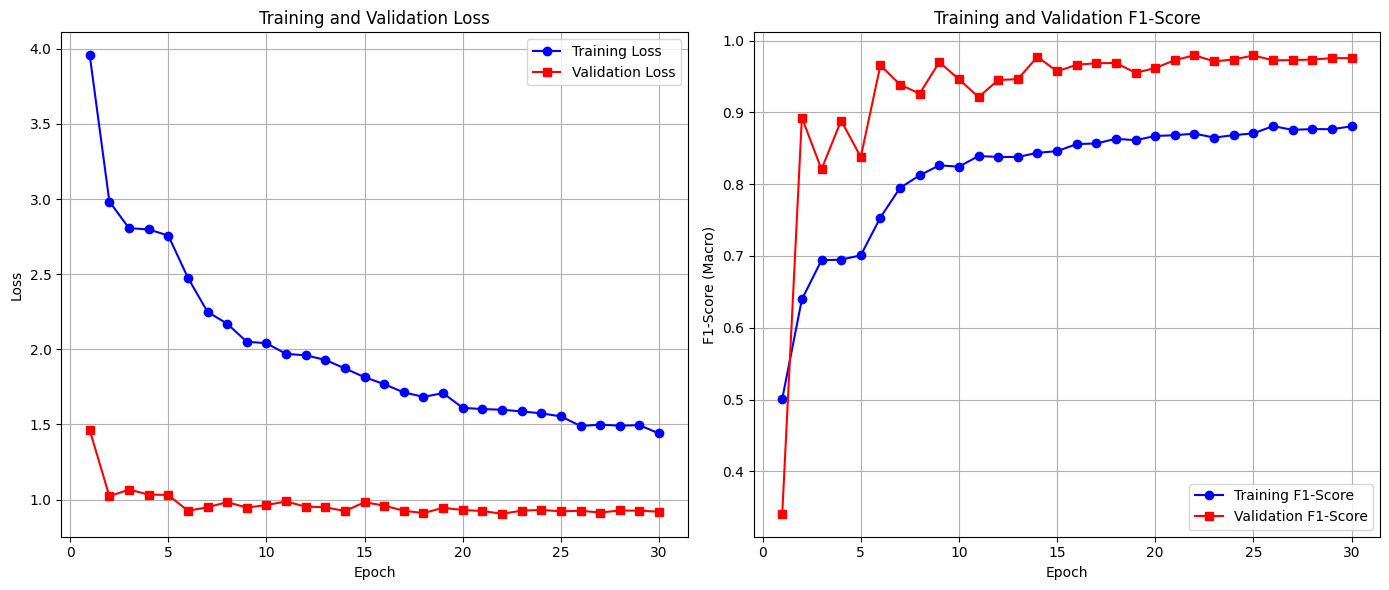

In [26]:
import matplotlib.pyplot as plt

# Place this AFTER your main training loop
epochs_ran = len(history['train_loss'])
epochs = range(1, epochs_ran + 1)

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-s', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot F1-Score
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_f1'], 'b-o', label='Training F1-Score')
plt.plot(epochs, history['val_f1'], 'r-s', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score (Macro)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

Loading best model from best_model.pth (Epoch 22)


Generating Confusion Matrix: 100%|██████████| 826/826 [02:36<00:00,  5.29it/s]


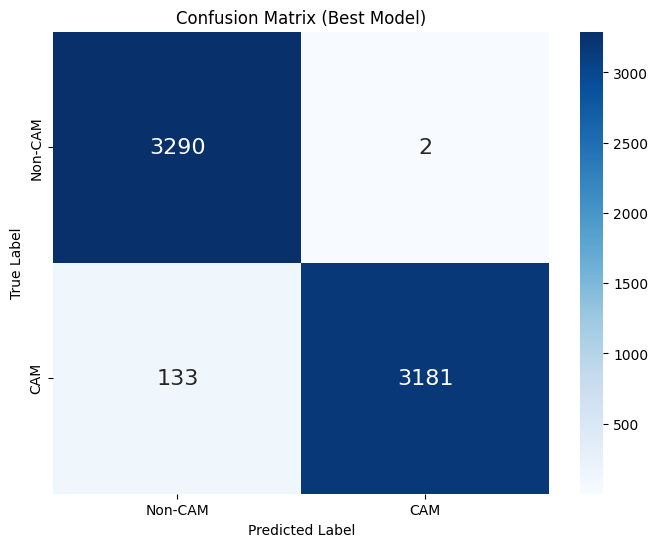


Classification Report (Best Model):

              precision    recall  f1-score   support

     Non-CAM       0.96      1.00      0.98      3292
         CAM       1.00      0.96      0.98      3314

    accuracy                           0.98      6606
   macro avg       0.98      0.98      0.98      6606
weighted avg       0.98      0.98      0.98      6606



In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Load the best model weights
print(f"Loading best model from {SAVE_PATH} (Epoch {best_epoch})")
checkpoint = torch.load(SAVE_PATH, weights_only=False)
model.load_state_dict(checkpoint['model_state'])
model.to(device)
model.eval()

# Get predictions from the BEST model
all_preds = []
all_labels = []

with torch.no_grad():
    for weak_imgs, _, labels, _ in tqdm(val_loader, desc="Generating Confusion Matrix"):
        imgs = weak_imgs.to(device)
        out = model(imgs)
        logits = out["logits"]
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['Non-CAM', 'CAM'] # Assuming 0=Non-CAM, 1=CAM

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

# Optional: Print detailed classification report
print("\nClassification Report (Best Model):\n")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

Extracting features for t-SNE: 100%|██████████| 826/826 [02:36<00:00,  5.29it/s]


Running t-SNE on 6606 samples...


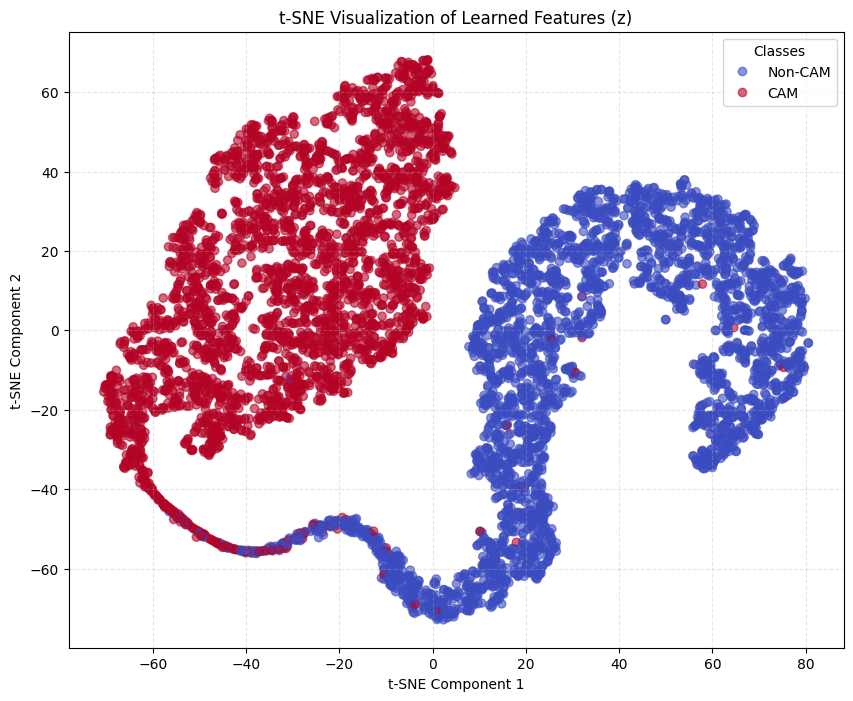

In [28]:
from sklearn.manifold import TSNE

# Get features (z) from the BEST model
all_feats = []
all_labels = []

model.eval()
with torch.no_grad():
    for weak_imgs, _, labels, _ in tqdm(val_loader, desc="Extracting features for t-SNE"):
        imgs = weak_imgs.to(device)
        out = model(imgs)
        all_feats.append(out["feat"].cpu())
        all_labels.append(labels.cpu())

all_feats = torch.cat(all_feats).numpy()
all_labels = torch.cat(all_labels).numpy()

print(f"Running t-SNE on {all_feats.shape[0]} samples...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(all_feats)

# Plot t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_labels, cmap='coolwarm', alpha=0.6)
plt.title('t-SNE Visualization of Learned Features (z)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, _ = scatter.legend_elements()
plt.legend(handles, ['Non-CAM', 'CAM'], title='Classes')
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig('tsne_features.png')
plt.show()

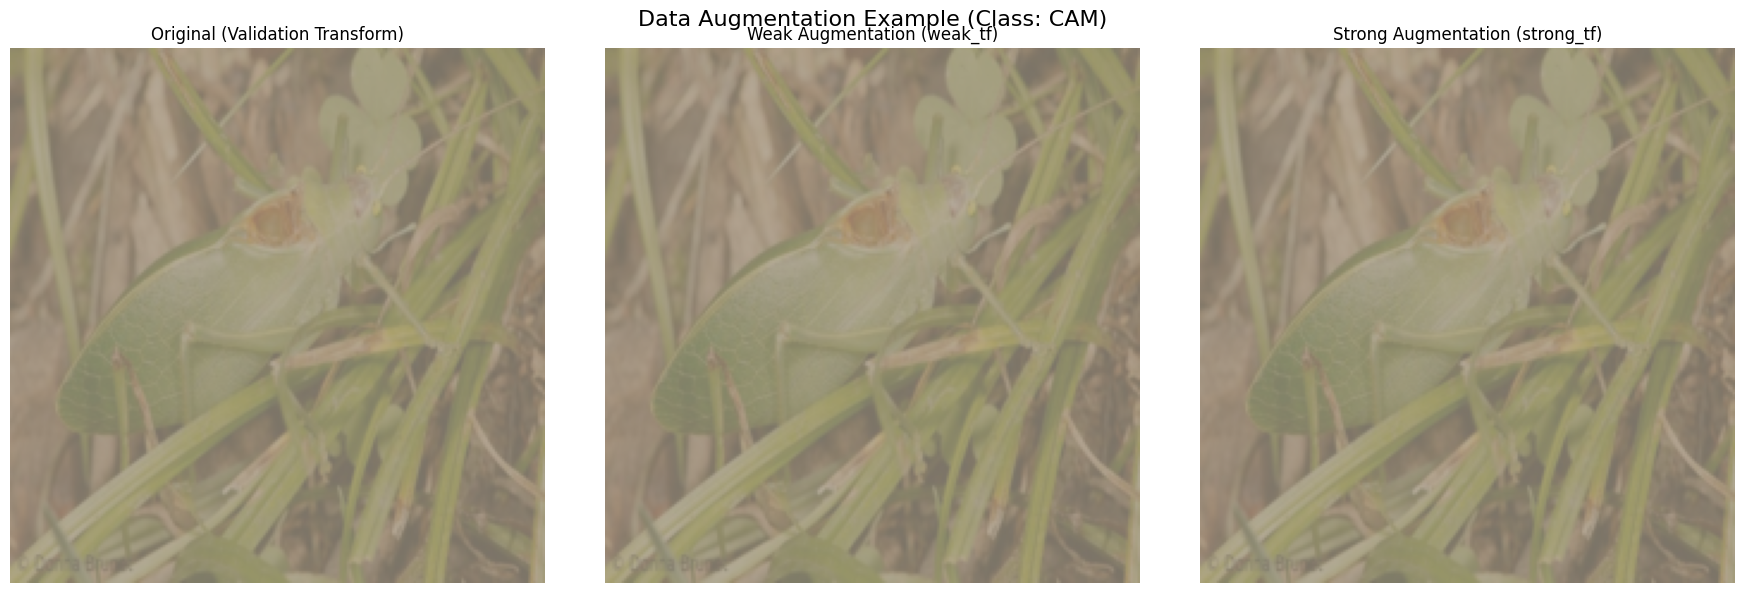

In [29]:
# Inverse normalization for plotting
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Get a sample from the validation dataset (which uses val_tf)
# We need to re-load the PIL image to apply weak/strong transforms
sample_idx = 10 # Pick any sample
img_path, label = val_ds.samples[sample_idx][0], val_ds.samples[sample_idx][1]
img_pil = Image.open(img_path).convert("RGB")

# Apply the transforms
# Note: Your train_ds transforms are defined globally as weak_tf and strong_tf
img_val_tensor = val_tf(img_pil)
img_weak_tensor = weak_tf(img_pil)
img_strong_tensor = strong_tf(img_pil)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Data Augmentation Example (Class: {"CAM" if label==1 else "Non-CAM"})', fontsize=16)

# Original (from val_tf)
axes[0].imshow(denormalize(img_val_tensor).permute(1, 2, 0).clip(0, 1))
axes[0].set_title('Original (Validation Transform)')
axes[0].axis('off')

# Weak Augmentation
axes[1].imshow(denormalize(img_weak_tensor).permute(1, 2, 0).clip(0, 1))
axes[1].set_title('Weak Augmentation (weak_tf)')
axes[1].axis('off')

# Strong Augmentation
axes[2].imshow(denormalize(img_strong_tensor).permute(1, 2, 0).clip(0, 1))
axes[2].set_title('Strong Augmentation (strong_tf)')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('augmentation_example.png')
plt.show()

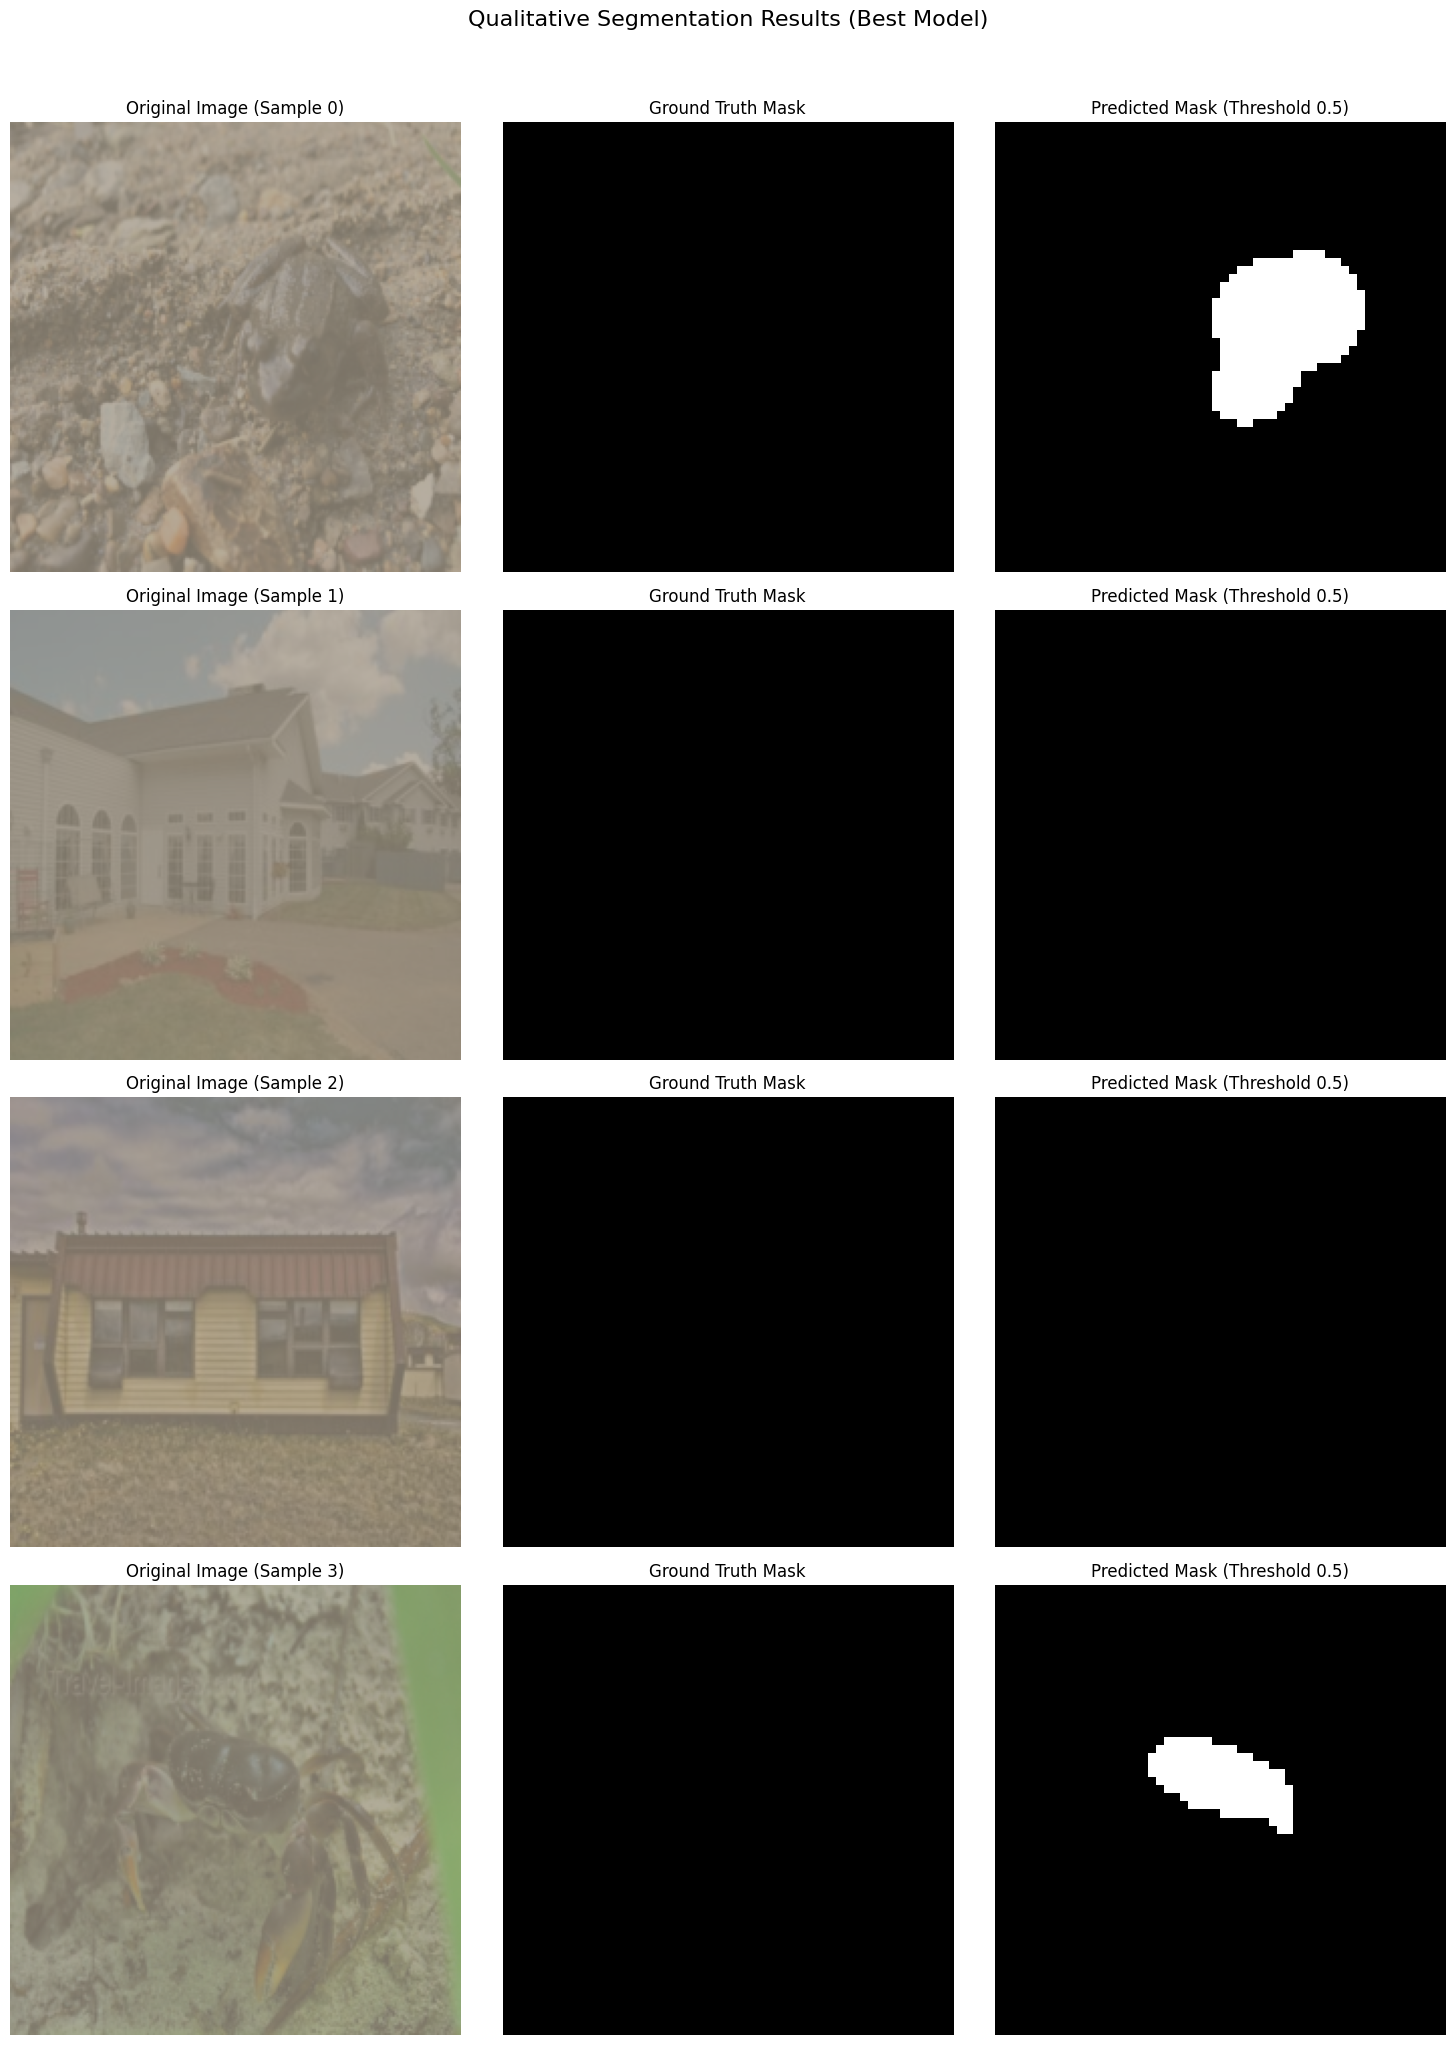

In [30]:
# Load the best model
checkpoint = torch.load(SAVE_PATH, weights_only=False)
model.load_state_dict(checkpoint['model_state'])
model.to(device)
model.eval()

# Get a batch from the validation loader
data_iter = iter(val_loader)
weak_imgs, _, labels, masks = next(data_iter)

# Select a few images to show
num_to_show = 4
imgs_to_plot = weak_imgs[:num_to_show].to(device)
masks_to_plot = masks[:num_to_show].to(device)

# Get model predictions
with torch.no_grad():
    out = model(imgs_to_plot)
    seg_preds = out['seg'] # These are logits
    seg_probs = torch.sigmoid(seg_preds) # Probabilities [0, 1]
    seg_binary = (seg_probs > 0.5).float() # Binary mask

# Move to CPU for plotting
imgs_to_plot = imgs_to_plot.cpu()
masks_to_plot = masks_to_plot.cpu()
seg_binary = seg_binary.cpu()

fig, axes = plt.subplots(num_to_show, 3, figsize=(15, 5 * num_to_show))
fig.suptitle('Qualitative Segmentation Results (Best Model)', fontsize=16, y=1.02)

for i in range(num_to_show):
    # Denormalize image
    img = denormalize(imgs_to_plot[i]).permute(1, 2, 0).clip(0, 1)
    
    # 1. Original Image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Original Image (Sample {i})')
    axes[i, 0].axis('off')

    # 2. Ground Truth Mask
    axes[i, 1].imshow(masks_to_plot[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')
    axes[i, 1].axis('off')

    # 3. Predicted Mask
    axes[i, 2].imshow(seg_binary[i].squeeze(), cmap='gray')
    axes[i, 2].set_title('Predicted Mask (Threshold 0.5)')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('segmentation_results.png')
plt.show()

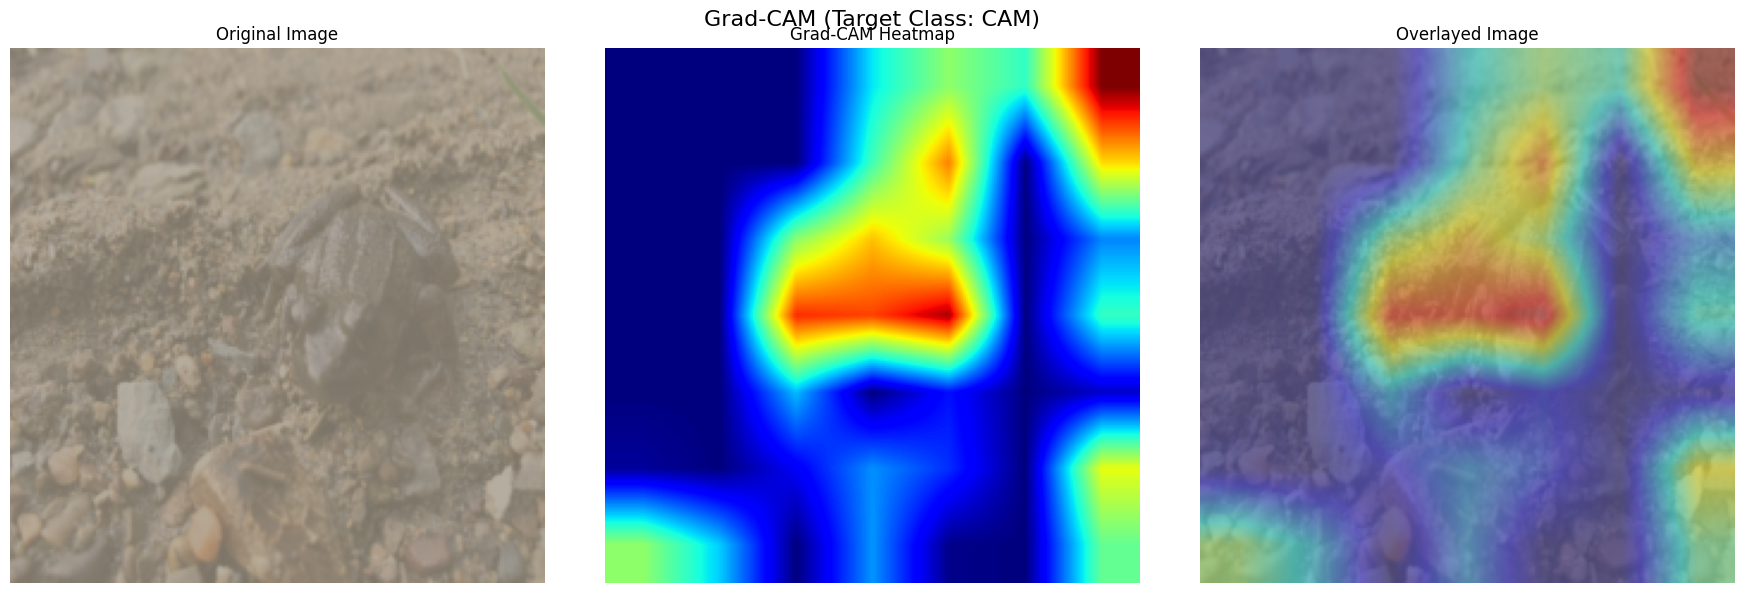

In [31]:
import cv2 # OpenCV is often used for heatmap overlay

# Load the best model
checkpoint = torch.load(SAVE_PATH, weights_only=False)
model.load_state_dict(checkpoint['model_state'])
model.to(device)
model.eval()

# Get a sample
data_iter = iter(val_loader)
weak_imgs, _, labels, _ = next(data_iter)

# Select one image
img_tensor = weak_imgs[0].unsqueeze(0).to(device) # [1, 3, 224, 224]
label = labels[0].item()

# Use your provided Grad-CAM function
# Let's target the last DenseNet block as you did
heatmap_np = get_gradcam_heatmap(
    model, 
    img_tensor, 
    target_class=label, 
    layer_name='backA.features.denseblock4' # Or try 'backS.model.stages.3'
)

# Convert tensor image back to plottable format
img_np = denormalize(img_tensor.squeeze().cpu()).permute(1, 2, 0).numpy().clip(0, 1)
# Convert to 8-bit for OpenCV
img_bgr = cv2.cvtColor((img_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

# Resize heatmap and apply colormap
heatmap_resized = cv2.resize(heatmap_np, (img_bgr.shape[1], img_bgr.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Superimpose heatmap
superimposed_img = cv2.addWeighted(heatmap_colored, 0.4, img_bgr, 0.6, 0)
superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Grad-CAM (Target Class: {"CAM" if label==1 else "Non-CAM"})', fontsize=16)

axes[0].imshow(img_np)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(heatmap_resized, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap')
axes[1].axis('off')

axes[2].imshow(superimposed_img_rgb)
axes[2].set_title('Overlayed Image')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('gradcam_result.png')
plt.show()